# Esame TRMD

## Miscentering distribution di ammassi eROSITA

### Fabio Zinzone

Lo scopo, in questo notebook, è analizzare la distribuzione di miscentering degli ammassi di galassie utilizzando i dati della survey eROSITA. 

## Parte I

Preliminarmente vengono importati i pacchetti e gli strumenti di python da utilizzare in seguito.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import emcee
from scipy.optimize import minimize
import warnings
import logging
import pygtc
from scipy.stats import chi2

Vengono scaricati i dati del catalogo e visualizzati per intero tramite pandas.

In [2]:
df = pd.read_csv('catalog_selected_columns_filtered_with_cluster_index.csv')
data = df.to_numpy() #creazione di un array numpy dal dataframe pandas
df

,Unnamed: 0,NAME,RA_XFIT,DEC_XFIT,M500,R500,RA_OPT,DEC_OPT,RA_BCG,DEC_BCG,...,X_scaled_0,X_scaled_1,cluster,rho_m,rho_s,sigma0_m,sigma0_s,sigma1_m,sigma1_s,logM500
0,0,1eRASS J000005.2-383729,0.0214,-38.6250,36.07,971.0,0.023800,-38.626781,0.023800,-38.626781,...,-0.081623,0.778435,6,0.750582,0.027508,0.100183,0.007995,0.668959,0.040839,14.557146
1,1,1eRASS J000021.4-824954,0.0558,-82.8189,16.99,819.0,0.176800,-82.798203,0.176800,-82.798203,...,-1.230286,-0.425019,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.230193
2,2,1eRASS J000031.8-630131,0.1265,-63.0225,22.04,846.0,0.125400,-63.023071,0.125400,-63.023071,...,-0.439542,-0.046329,9,0.809312,0.024625,0.089089,0.006957,0.578245,0.038856,14.343212
3,3,1eRASS J000056.7-682010,0.2309,-68.3369,14.25,732.0,0.230100,-68.336777,0.176500,-68.372871,...,-0.456453,-0.657230,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.153815
4,4,1eRASS J000104.0-464435,0.2768,-46.7381,23.84,891.0,0.284000,-46.734661,0.284000,-46.734661,...,-0.809294,0.075927,22,0.779619,0.029719,0.058439,0.005577,0.514526,0.037597,14.377306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,7703,1eRASS J235805.6-403027,359.5230,-40.5073,11.51,692.0,359.557709,-40.486210,359.557709,-40.486210,...,-0.670809,-0.913151,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.061075
7563,7704,1eRASS J235848.7-612554,359.7070,-61.4319,21.82,800.0,359.700287,-61.433041,359.700287,-61.433041,...,0.278480,-0.061689,29,0.768367,0.033628,0.181056,0.018008,0.775150,0.052974,14.338855
7564,7705,1eRASS J235858.0-603644,359.6968,-60.6172,38.67,1071.0,359.767090,-60.609489,359.618896,-60.563850,...,-1.148322,0.905424,2,0.730593,0.032936,0.039728,0.003903,0.506667,0.035547,14.587374
7565,7706,1eRASS J235927.5-341821,359.8642,-34.3077,14.11,763.0,359.865387,-34.306438,359.865387,-34.306438,...,-1.104801,-0.669692,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.149527


Per comodità vengono individuati gli indici di colonna delle tre grandezze che si vogliono analizzare, sfruttando la funzione get_loc di pandas.

In [3]:
nz = df.columns.get_loc('BEST_Z') #redshift
nm = df.columns.get_loc('logM500') #massa
nnd = df.columns.get_loc('BCG_offset_R500') #distanza normalizzata

Vengono ora visualizzate, agli estremi, solo le tre colonne interessate, tramite iloc di pandas.

In [4]:
ntot = data[:,nnd].shape[0] #numero di dati
col = [nz,nm,nnd] #array di interi con gli indici di colonna
dfx = df.iloc[:, col] #dataframe ristretto
dfx

,BEST_Z,logM500,BCG_offset_R500
0,0.31528,14.557146,0.044778
1,0.08909,14.230193,0.189587
2,0.24480,14.343212,0.012553
3,0.24147,14.153815,0.781392
4,0.17199,14.377306,0.071918
...,...,...,...
7562,0.19926,14.061075,0.585099
7563,0.38619,14.338855,0.081668
7564,0.10523,14.587374,0.430328
7565,0.11380,14.149527,0.015736


Viene preparato l'istogramma dei dati delle distanze normalizzate, sia per numpy che per matplotlib. Infatti, oltre che per il grafico, è utile calcolare l'area di esso per motivi di normalizzazione che torneranno utili per i fit.

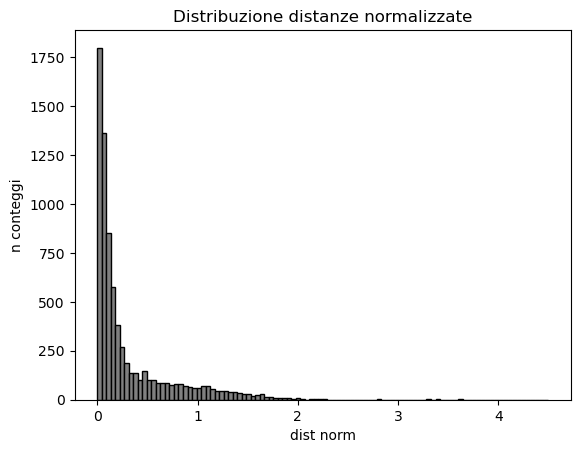

In [5]:
nbi = 100 #parametro modificabile per i bin dell'istogramma
xmn = 0. #parametro di ascissa minima
histo, _ = np.histogram(data[:,nnd],bins=nbi) #array di interi per le altezze delle colonne
_ , bins = np.histogram(data[:,nnd],bins=nbi) #array di reali per gli estremi dei bin
dx = bins[1] - bins[0] #larghezza del rettangolo
area = ( bins[1] - bins[0] ) * np.sum(histo) #somma delle aree dei rettangoli
xc = np.linspace(xmn+dx/2. , xmn+dx/2. + (nbi-1)*dx , nbi) #array di punti medi dei rettangoli
plt.hist(data[:,nnd], bins=nbi, color="grey", edgecolor="black")
plt.title("Distribuzione distanze normalizzate")
plt.xlabel("dist norm")
plt.ylabel("n conteggi")
plt.show()

Ora la variazione delle distanze normalizzate in funzione della massa.

<function matplotlib.pyplot.show(close=None, block=None)>

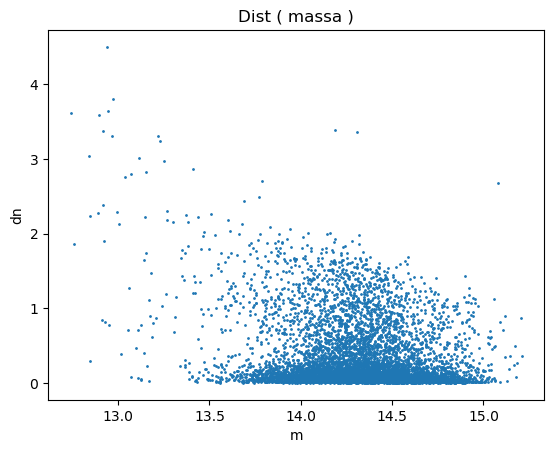

In [6]:
sortind = np.argsort(data[:, nm]) #funzione numpy per ordinare i dati
sdata = data[sortind]
plt.scatter(sdata[:,nm], sdata[:,nnd], s=1)
plt.title("Dist ( massa )")
plt.xlabel("m")
plt.ylabel("dn")
plt.show

Ora la variazione delle distanze normalizzate in funzione del redshift.

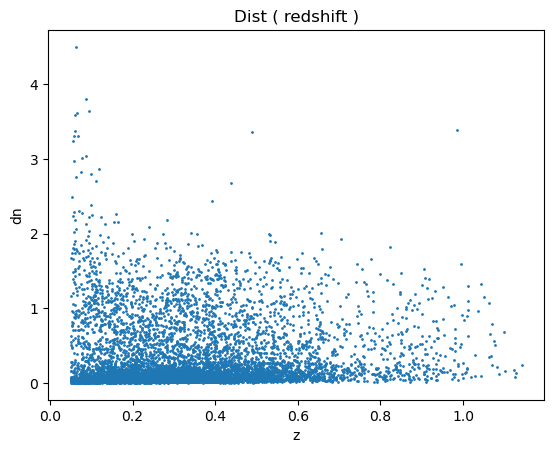

In [7]:
sortind = np.argsort(data[:, nz])
sdata = data[sortind]
plt.scatter(sdata[:,nz], sdata[:,nnd], s=1)
plt.title("Dist ( redshift )")
plt.xlabel("z")
plt.ylabel("dn")
plt.show()

In entrambi i casi, sia usando il plot che lo scatter di matplotlib, non sembra esserci una relazione riconoscibile tra le grandezze, come una funzione analitica nota o quantomeno una curva da studiare numericamente. Le uniche informazioni che si possono trarre sono l'addensamento di punti in prossimità di basse distanze e di range ristretti di massa e di redshift.

## Parte II

Vengono importati i due modelli, S15 e Z19, tramite un'unica funzione, con un parametro per selezionarne uno dei due, oltre che la variabile e i tre parametri caratteristici.

In [8]:
def model(x,ro,s0,s1,i):
    if i==1: #Saro 2015
        sy1 = ro * (x / s0**2.) * np.exp(-0.5 * (x / s0)**2.)
        sy2 = (1. - ro) * (x / s1**2.) * np.exp(-0.5 * (x / s1)**2.)
        sy = sy1 + sy2
        return sy
    elif i==2: #Zhang 2019
        zy1 = (ro / s0) * np.exp(-x / s0)
        zy2 = ((1. - ro) / s1) * np.exp(-x / s1)
        zy = zy1 + zy2
        return zy

Vengono scelti alcuni set di parametri per studiare gli andamenti dei modelli. Si cerca di provare gli estremi almeno per il parametro frazionario, e ovviamente per comprendere meglio l'andamento del modello il numero di combinazioni da testare dovrebbe essere molto maggiore.

In [9]:
szx = np.linspace(0,4,100) #array delle ascisse uguale per tutti
par1 = np.array([0.1,0.1,0.1]) #array di un set di parametri
par2 = np.array([0.1,0.1,0.9])
par3 = np.array([0.1,0.9,0.1])
par4 = np.array([0.5,0.1,0.9])
par5 = np.array([0.5,0.9,0.1])
par6 = np.array([0.9,0.1,0.9])
par7 = np.array([0.9,0.9,0.1])
par8 = np.array([0.9,0.9,0.9])

Per il modello Saro vengono graficati otto grafici, uno per ogni parametro, tramite la funzione subplots di matplotlib.

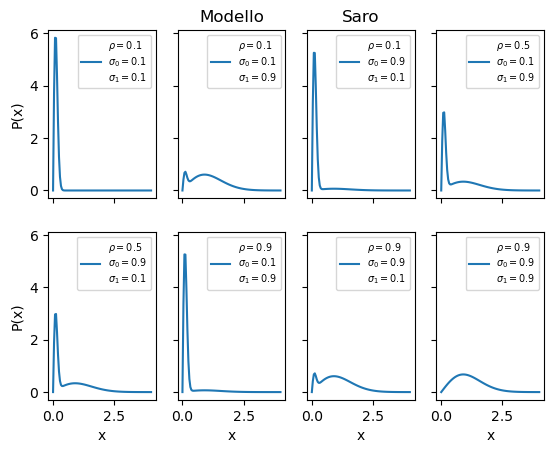

In [10]:
sy1 = model(szx,par1[0],par1[1],par1[2],1) #array del modello in funzione delle ascisse
sy2 = model(szx,par2[0],par2[1],par2[2],1)
sy3 = model(szx,par3[0],par3[1],par3[2],1)
sy4 = model(szx,par4[0],par4[1],par4[2],1)
sy5 = model(szx,par5[0],par5[1],par5[2],1)
sy6 = model(szx,par6[0],par6[1],par6[2],1)
sy7 = model(szx,par7[0],par7[1],par7[2],1)
sy8 = model(szx,par8[0],par8[1],par8[2],1)

fig, ((sax1,sax2,sax3,sax4), (sax5,sax6,sax7,sax8)) = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)

sax1.plot(szx,sy1, label=r'$\rho = 0.1$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.1$') 
sax2.plot(szx,sy2, label=r'$\rho = 0.1$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.9$')
sax3.plot(szx,sy3, label=r'$\rho = 0.1$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.1$')
sax4.plot(szx,sy4, label=r'$\rho = 0.5$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.9$')
sax5.plot(szx,sy5, label=r'$\rho = 0.5$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.1$')
sax6.plot(szx,sy6, label=r'$\rho = 0.9$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.9$')
sax7.plot(szx,sy7, label=r'$\rho = 0.9$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.1$')
sax8.plot(szx,sy8, label=r'$\rho = 0.9$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.9$')

sax2.set_title("Modello"), sax3.set_title("Saro")
sax5.set_xlabel("x"), sax6.set_xlabel("x"), sax7.set_xlabel("x"), sax8.set_xlabel("x")
sax1.set_ylabel("P(x)"), sax5.set_ylabel("P(x)")

sax1.legend(loc='upper right', fontsize='x-small')
sax2.legend(loc='upper right', fontsize='x-small')
sax3.legend(loc='upper right', fontsize='x-small')
sax4.legend(loc='upper right', fontsize='x-small')
sax5.legend(loc='upper right', fontsize='x-small')
sax6.legend(loc='upper right', fontsize='x-small')
sax7.legend(loc='upper right', fontsize='x-small')
sax8.legend(loc='upper right', fontsize='x-small')

plt.show()

Stessa cosa per il modello Zhang.

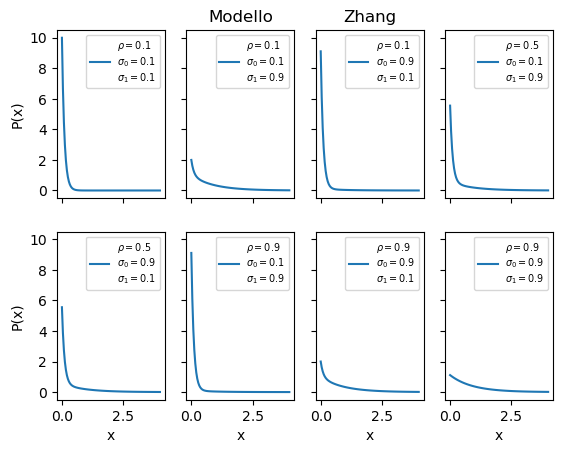

In [11]:
zy1 = model(szx,par1[0],par1[1],par1[2],2)
zy2 = model(szx,par2[0],par2[1],par2[2],2)
zy3 = model(szx,par3[0],par3[1],par3[2],2)
zy4 = model(szx,par4[0],par4[1],par4[2],2)
zy5 = model(szx,par5[0],par5[1],par5[2],2)
zy6 = model(szx,par6[0],par6[1],par6[2],2)
zy7 = model(szx,par7[0],par7[1],par7[2],2)
zy8 = model(szx,par8[0],par8[1],par8[2],2)

fig, ((zax1,zax2,zax3,zax4), (zax5,zax6,zax7,zax8)) = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
zax1.plot(szx,zy1, label=r'$\rho = 0.1$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.1$')
zax2.plot(szx,zy2, label=r'$\rho = 0.1$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.9$')
zax3.plot(szx,zy3, label=r'$\rho = 0.1$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.1$')
zax4.plot(szx,zy4, label=r'$\rho = 0.5$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.9$')
zax5.plot(szx,zy5, label=r'$\rho = 0.5$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.1$')
zax6.plot(szx,zy6, label=r'$\rho = 0.9$' + '\n' + r'$\sigma_0 = 0.1$' + '\n' + r'$\sigma_1 = 0.9$')
zax7.plot(szx,zy7, label=r'$\rho = 0.9$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.1$')
zax8.plot(szx,zy8, label=r'$\rho = 0.9$' + '\n' + r'$\sigma_0 = 0.9$' + '\n' + r'$\sigma_1 = 0.9$')

zax2.set_title("Modello"), zax3.set_title("Zhang")
zax5.set_xlabel("x"), zax6.set_xlabel("x"), zax7.set_xlabel("x"), zax8.set_xlabel("x")
zax1.set_ylabel("P(x)"), zax5.set_ylabel("P(x)")

zax1.legend(loc='upper right', fontsize='x-small')
zax2.legend(loc='upper right', fontsize='x-small')
zax3.legend(loc='upper right', fontsize='x-small')
zax4.legend(loc='upper right', fontsize='x-small')
zax5.legend(loc='upper right', fontsize='x-small')
zax6.legend(loc='upper right', fontsize='x-small')
zax7.legend(loc='upper right', fontsize='x-small')
zax8.legend(loc='upper right', fontsize='x-small')

plt.show()

In entrambi i casi si possono individuare combinazioni di parametri che danno grafici simili se non uguali, quando essi vengono "invertiti", per esempio da 0.1 a 0.9 e vicerversa. Uno studio migliore di questi modelli consisterebbe in grafici 3D (limite visivo) per due parametri alla volta, o grafici 2D o 3D variabili nel "tempo", cioè nel parametro in questione.

## Parte III

Per fittare i modelli si fa uso della statistica bayesiana. Dal teorema di Bayes e dalla proprietà dei logaritmi, ho che la log_posterior è data dalla somma di una log_prior e una log_likelihood. 

I prior vengono scelti piatti per i parametri, tenendo conto che rho, in quanto frazione, è compreso tra 0 e 1, mentre le due deviazioni sono maggiori di 0.

Come doppia likelihood viene assunta la distribuzione del modello (con la scelta), per definizione generale della likelihood, quindi alla fine il log della distribuzione congiunta dei dati.

Infine una doppia log_posterior data dalla somma delle due.

In [12]:
def log_prior(theta):
    ro, s0, s1 = theta
    if 0. <= ro <= 1. and s0 > 0. and s1 > 0.:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, i):
    ro, s0, s1 = theta
    y = np.sum([np.log(model(xi, ro, s0, s1, i)) for xi in x])
    return y

def slog_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, 1)

def zlog_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, 2)

Viene poi utilizzato l'algoritmo EMCEE per fittare i tre parametri: particolare algoritmo di Monte Carlo a catena di Markov efficiente, con un approccio di campionamento preferibile rispetto a una catena sequenziale. Lo stesso procedimento viene fatto due volte separatamente, per i modelli. Cambia la likelihood, e di conseguenza la posterior.

### Saro 2015

Partendo dal primo modello, si può ora fittare i parametri. Da scipy era stato importata la funzione minimize, infatti, prima di applicare effettivamente l'algoritmo EMCEE ed esplorare lo spazio dei parametri con i walkers, conviene avere un punto di partenza, il massimo della log_posterior, quindi il minimo dell'opposta. Da un punto iniziale perturbato, nello spazio dei parametri, viene applocata la funzione. Vengono volutamente ignorati i warnings dovuti probabilmente a valori numerici problematici, in ogni caso si ottiene una soluzione.

In [13]:
warnings.filterwarnings("ignore", message="invalid value encountered in subtract", category=RuntimeWarning)
np.random.seed(42)
snll = lambda *args: -slog_posterior(*args)
sinitial = np.array([0.9, 0.7, 1.])*(1+ 0.1 * np.random.randn(3))
ssoln = minimize(snll, sinitial, args=(data[:,nnd]))
sro_bf, ss0_bf, ss1_bf = ssoln.x
ssoln.x

array([0.62825884, 0.06699864, 0.62301053])

Si procede poi con l'algoritmo. Vengono scelti solo 10 walkers, che partiranno dal punto di minimo trovato, e 1000 step per motivi di tempistiche. 

In [14]:
spos = ssoln.x *(1+ 1e-4 * np.random.randn(10, 3))
snwalkers, sndim = spos.shape

ssampler = emcee.EnsembleSampler(
    snwalkers, sndim, slog_posterior, args=(data[:, nnd],)
)
ssampler.run_mcmc(spos, 1000, progress=True);

100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Vengono quindi graficate le posizioni dei walkers per ogni asse (quindi ogni parametro) in funzione del numero di step.

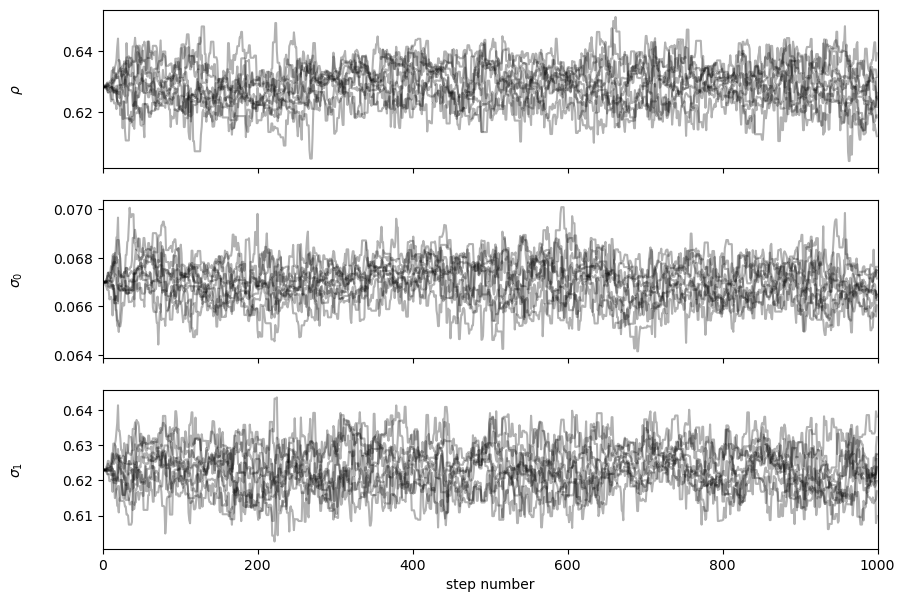

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
ssamples = ssampler.get_chain()
labels = [r'$\rho$', r'$\sigma_0$', r'$\sigma_1$']
for i in range(sndim):
    ax = axes[i]
    ax.plot(ssamples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(ssamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Viene omesso il calcolo del tempo di autocorrelazione, che si otterrebbe con sampler.get_autocorr_time(), a causa degli errori AutocorrError. Evitarli richiederebbe una catena molto più lunga, con conseguenti aumenti importanti delle tempistiche. 
Si procede poi, data la matrice che per ogni parametro da tutti i valori toccati nell'esplorazione del loro spazio, a fare una media per ogni colonna, definendo un nuovo array di tre componenti per i risultati. 

In [16]:
sflat_samples = ssampler.get_chain(discard=30, flat=True)
print(sflat_samples.shape)
sro = np.mean(sflat_samples[:,0])
ss0 = np.mean(sflat_samples[:,1])
ss1 = np.mean(sflat_samples[:,2])
stheta = [sro, ss0, ss1]
print(stheta)

(9700, 3)
[0.6288406002818833, 0.06701137285834888, 0.6231547699659915]


Tramite la libreria pygtc, precedentemente importata, è possibile visualizzare le distribuzioni marginali della posterior e le correlazioni tra parametri, con un grafico triangolare.

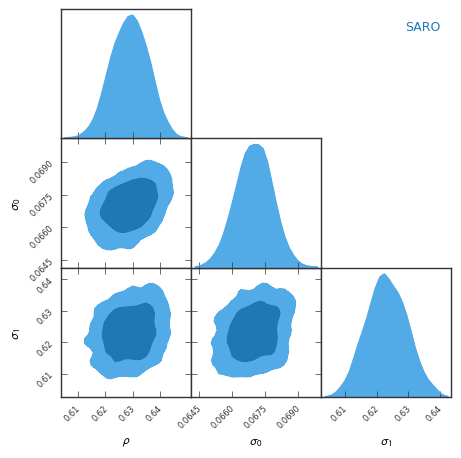

In [17]:
logging.getLogger('matplotlib.font_manager').disabled = True
GTC = pygtc.plotGTC(chains=sflat_samples,
                    paramNames=[r'$\rho$',r'$\sigma_0$',r'$\sigma_1$'],
                    chainLabels=['SARO'],
                    figureSize='MNRAS_page')

### Zhang 2019

La stessa identica procedura, da minimize a pygtc, viene ripetuta allo stesso modo per il secondo modello.

In [18]:
np.random.seed(42)
znll = lambda *args: -zlog_posterior(*args)
zinitial = np.array([0.9, 0.1, 0.9])*(1+ 0.1 * np.random.randn(3))
zsoln = minimize(znll, zinitial, args=(data[:,nnd]))
zro_bf, zs0_bf, zs1_bf = zsoln.x
zsoln.x

array([0.5380755 , 0.08712409, 0.58562101])

In [19]:
zpos = zsoln.x *(1+ 1e-4 * np.random.randn(10, 3))
znwalkers, zndim = zpos.shape

zsampler = emcee.EnsembleSampler(
    znwalkers, zndim, zlog_posterior, args=(data[:, nnd],)
)
zsampler.run_mcmc(zpos, 1000, progress=True);

100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


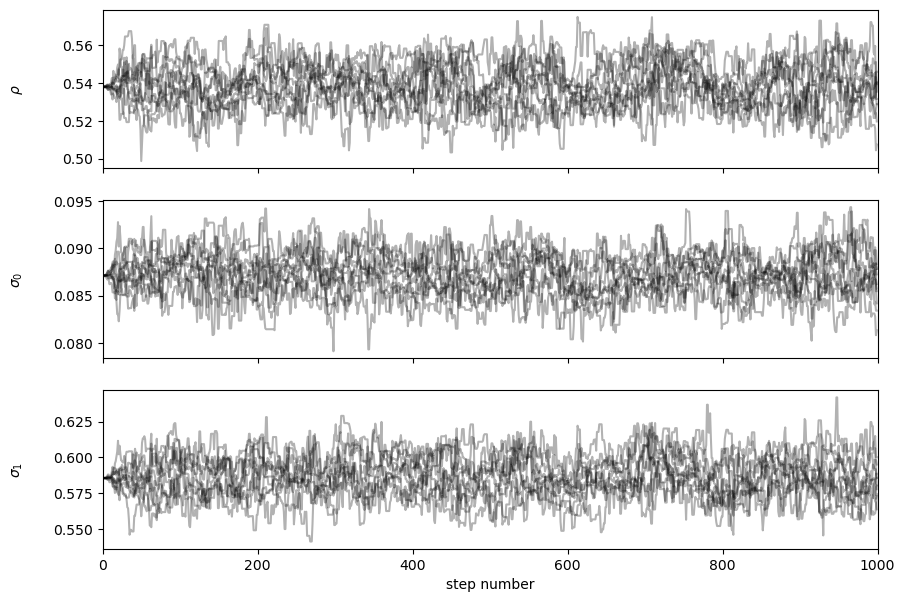

In [20]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
zsamples = zsampler.get_chain()
labels = [r'$\rho$', r'$\sigma_0$', r'$\sigma_1$']
for i in range(zndim):
    ax = axes[i]
    ax.plot(zsamples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(zsamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
zflat_samples = zsampler.get_chain(discard=100, flat=True)
print(zflat_samples.shape)
zro = np.mean(zflat_samples[:,0])
zs0 = np.mean(zflat_samples[:,1])
zs1 = np.mean(zflat_samples[:,2])
ztheta = [zro, zs0, zs1]
print(ztheta)

(9000, 3)
[0.5386930872346918, 0.08721293397593556, 0.5866808061630698]


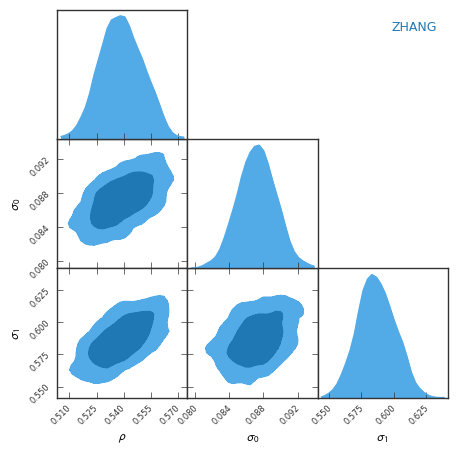

In [22]:
GTC = pygtc.plotGTC(chains=zflat_samples,
                    paramNames=[r'$\rho$',r'$\sigma_0$',r'$\sigma_1$'],
                    chainLabels=['ZHANG'],
                    figureSize='MNRAS_page')

### Confronto modelli

Dopo aver stimato i parametri, è possibile paragonare i due modelli, qualitativamente e quantitativamente.Vengono plottati insieme l'istogramma e la distribuzione con i parametri stimati. Prima per il modello Saro.

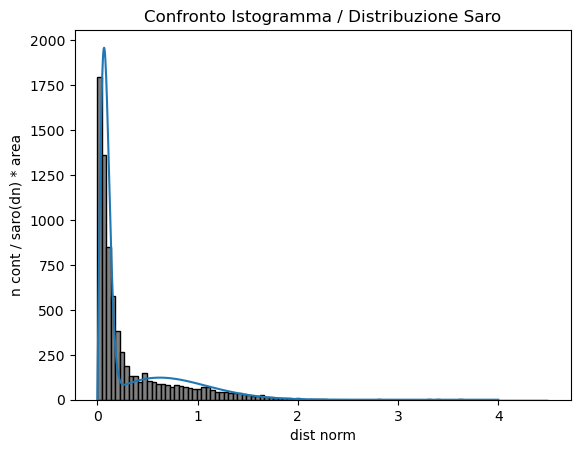

In [23]:
sxx = np.linspace(0.,4.,1000)
plt.hist(data[:,nnd], bins=nbi, color="grey", edgecolor="black")
syy = model(sxx,sro,ss0,ss1,1) * area
plt.plot(sxx,syy)
plt.title("Confronto Istogramma / Distribuzione Saro")
plt.xlabel("dist norm")
plt.ylabel("n cont / saro(dn) * area")
plt.show()

Dopo aver scelto un alpha, viene fatto un test del chi quadro per verificare l'attendibilità dei risultati. Si usa la statistica di test caratteristica per istogrammi e distribuzioni. E poi si trova il p_value tramite la funzione precedentemente importata chi2.cdf, distribuzione cumulativa, che calcola l'integrale da 0 alla statistica. 

In [24]:
alpha = 0.05 #livello di significatività
nfr = nbi - 1 - 3 #numero di gradi di libertà
syex = model(xc,sro,ss0,ss1,1) * dx * ntot
schi2t = np.sum( (histo - syex)**2. / syex )
print(schi2t)
sp_value = 1. - chi2.cdf(schi2t, nfr)
print(sp_value)

108338757.54972333
0.0


Stessa cosa per il modello Zhang.

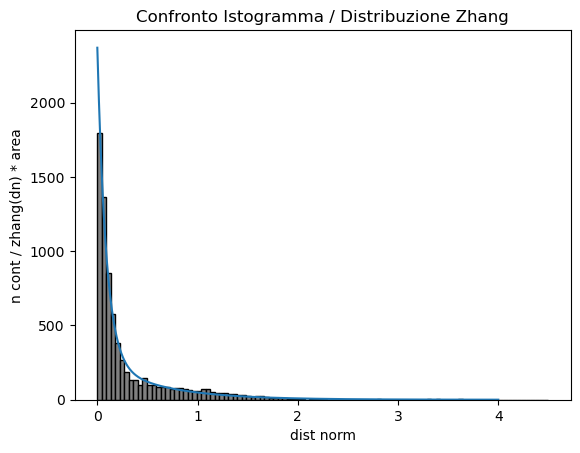

In [25]:
zxx = np.linspace(0.,4.,1000)
plt.hist(data[:,nnd], bins=nbi, color="grey", edgecolor="black")
zyy = model(zxx,zro,zs0,zs1,2) * area
plt.plot(zxx,zyy)
plt.title("Confronto Istogramma / Distribuzione Zhang")
plt.xlabel("dist norm")
plt.ylabel("n cont / zhang(dn) * area")
plt.show()

In [26]:
zyex = model(xc,zro,zs0,zs1,2) * dx * ntot
zchi2t = np.sum( (histo - zyex)**2. / zyex )
print(zchi2t)
zp_value = 1. - chi2.cdf(zchi2t, nfr)
print(zp_value)

263.44393257278233
0.0


## Conclusione

Graficamente, il secondo modello sembra riprodurre i dati sperimentali meglio del primo, e anche il test d'ipotesi conferma ciò, almeno per quanto riguarda il solo paragone tra i due. In generale, invece, i valori troppo alti del chi quadro non rendono possibile giustificare quantitativamente l'attendibilità di un modello. Per come è definita la chi2.cdf, è logico aspettarsi un valore nullo del p_value quando l'estremo di integrazione ha un ordine di grandezza maggiore degli estremi dell'istogramma. Per entrambi i modelli non si può parlare di un buon fit, e aumentare il numero di walkers e/o quello di step non sembra essere la soluzione, in quanto si può notare una stabilità già con questi numeri, inoltre aumenterebbero considerevolmente i tempi di esecuzione, soprattutto aumentando i walkers. Come in ogni problema di inferenza, che sia frequentista o bayesiana, aumentare il numero di dati darebbe risultati migliori, compensando almeno in parte le carenze e i problemi del metodo di fit. 